# Experiment 3: Regression Analysis using Linear and Regularized Models

**Institution:** Sri Sivasubramaniya Nadar College of Engineering, Chennai  
**Degree:** B.E. Computer Science & Engineering | **Semester:** VI  
**Subject:** UCS2612 – Machine Learning Algorithms Laboratory  
**Batch:** 2023–2027 | **Name:** Rahul V S | **RegisterNo:** 3122235001104

---

### **1. Aim and Objective**
To implement linear and regularized regression models (Ridge, Lasso, Elastic Net) for predicting the loan sanction amount. The experiment involves data preprocessing, exploratory data analysis, hyperparameter tuning using Cross-Validation, and a comprehensive analysis of overfitting, underfitting, and the bias-variance trade-off.

### **2. Dataset Description**
The dataset contains details of loan applications, including customer demographics, financial behavior, and property details.
* **Target Variable:** Loan Sanction Amount (USD)
* **Features:** A mix of numerical (e.g., Income, Loan Amount Request) and categorical (e.g., Profession, Location) variables.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

In [7]:
TRAIN_PATH = "train (2).csv"
TEST_PATH = "test.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

TARGET = "Loan Sanction Amount (USD)"
DROP_COLS = ["Customer ID", "Name", "Property ID", "Gender"]

train_df = train_df.dropna(subset=[TARGET]).copy()

X = train_df.drop(columns=[TARGET] + [c for c in DROP_COLS if c in train_df.columns])
y = train_df[TARGET]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

print(f"Training Features Shape: {X.shape}")
print(f"Numerical Columns: {len(num_cols)}")
print(f"Categorical Columns: {len(cat_cols)}")

Training Features Shape: (29660, 19)
Numerical Columns: 11
Categorical Columns: 8


In [ ]:
train_df


,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,...,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,C-43723,Angelyn Clevenger,M,38,4969.41,Low,Commercial associate,Managers,Urban,76657.90,...,869.61,0,Unpossessed,566,4969.41,4,Urban,1,111096.56,68992.11
29996,C-32511,Silas Slaugh,M,20,1606.88,Low,Working,Laborers,Semi-Urban,66595.14,...,729.41,0,Inactive,175,1606.88,3,Urban,1,73453.94,46616.60
29997,C-5192,Carmelo Lone,F,49,NaN,Low,Working,Sales staff,Urban,81410.08,...,NaN,0,Active,959,NaN,1,Rural,1,102108.02,61057.56
29998,C-12172,Carolann Osby,M,38,2417.71,Low,Working,Security staff,Semi-Urban,142524.10,...,677.27,1,Unpossessed,375,2417.71,4,Urban,1,168194.47,99766.87


### **3. Exploratory Data Analysis (EDA)**
Visualizing the distribution of the target variable and key features.

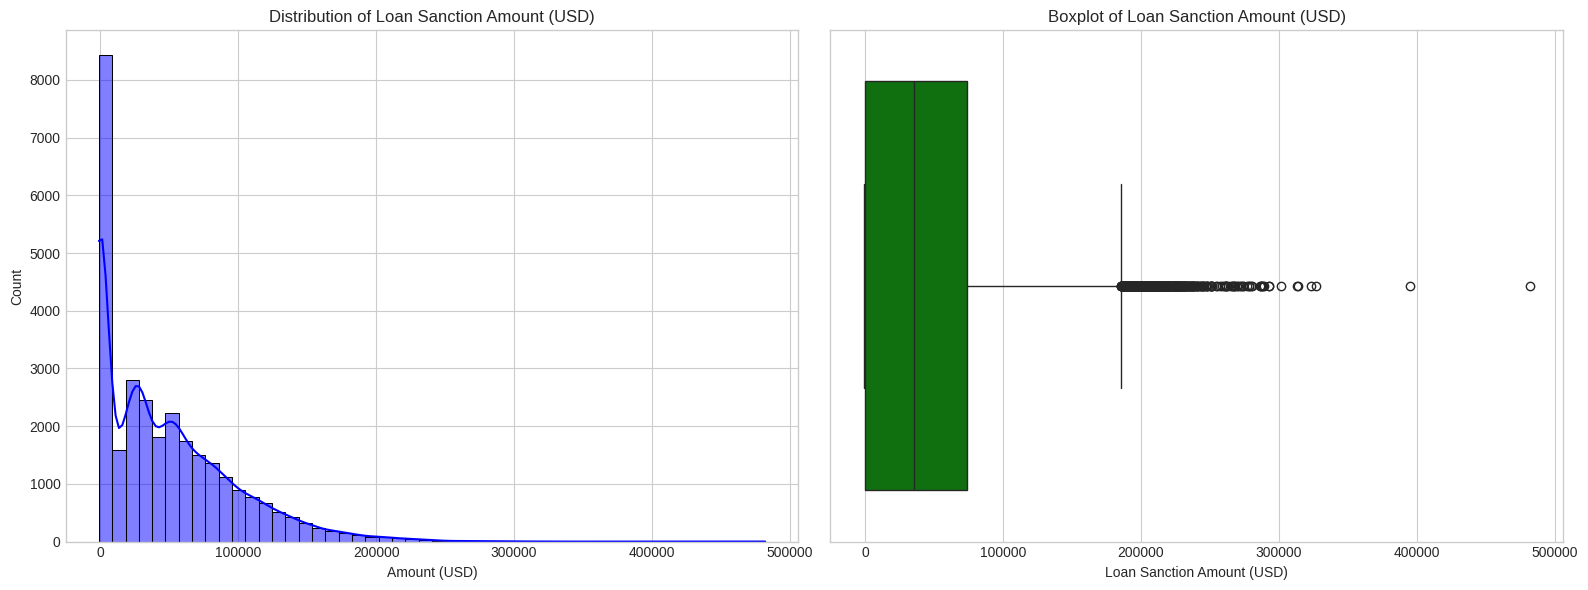

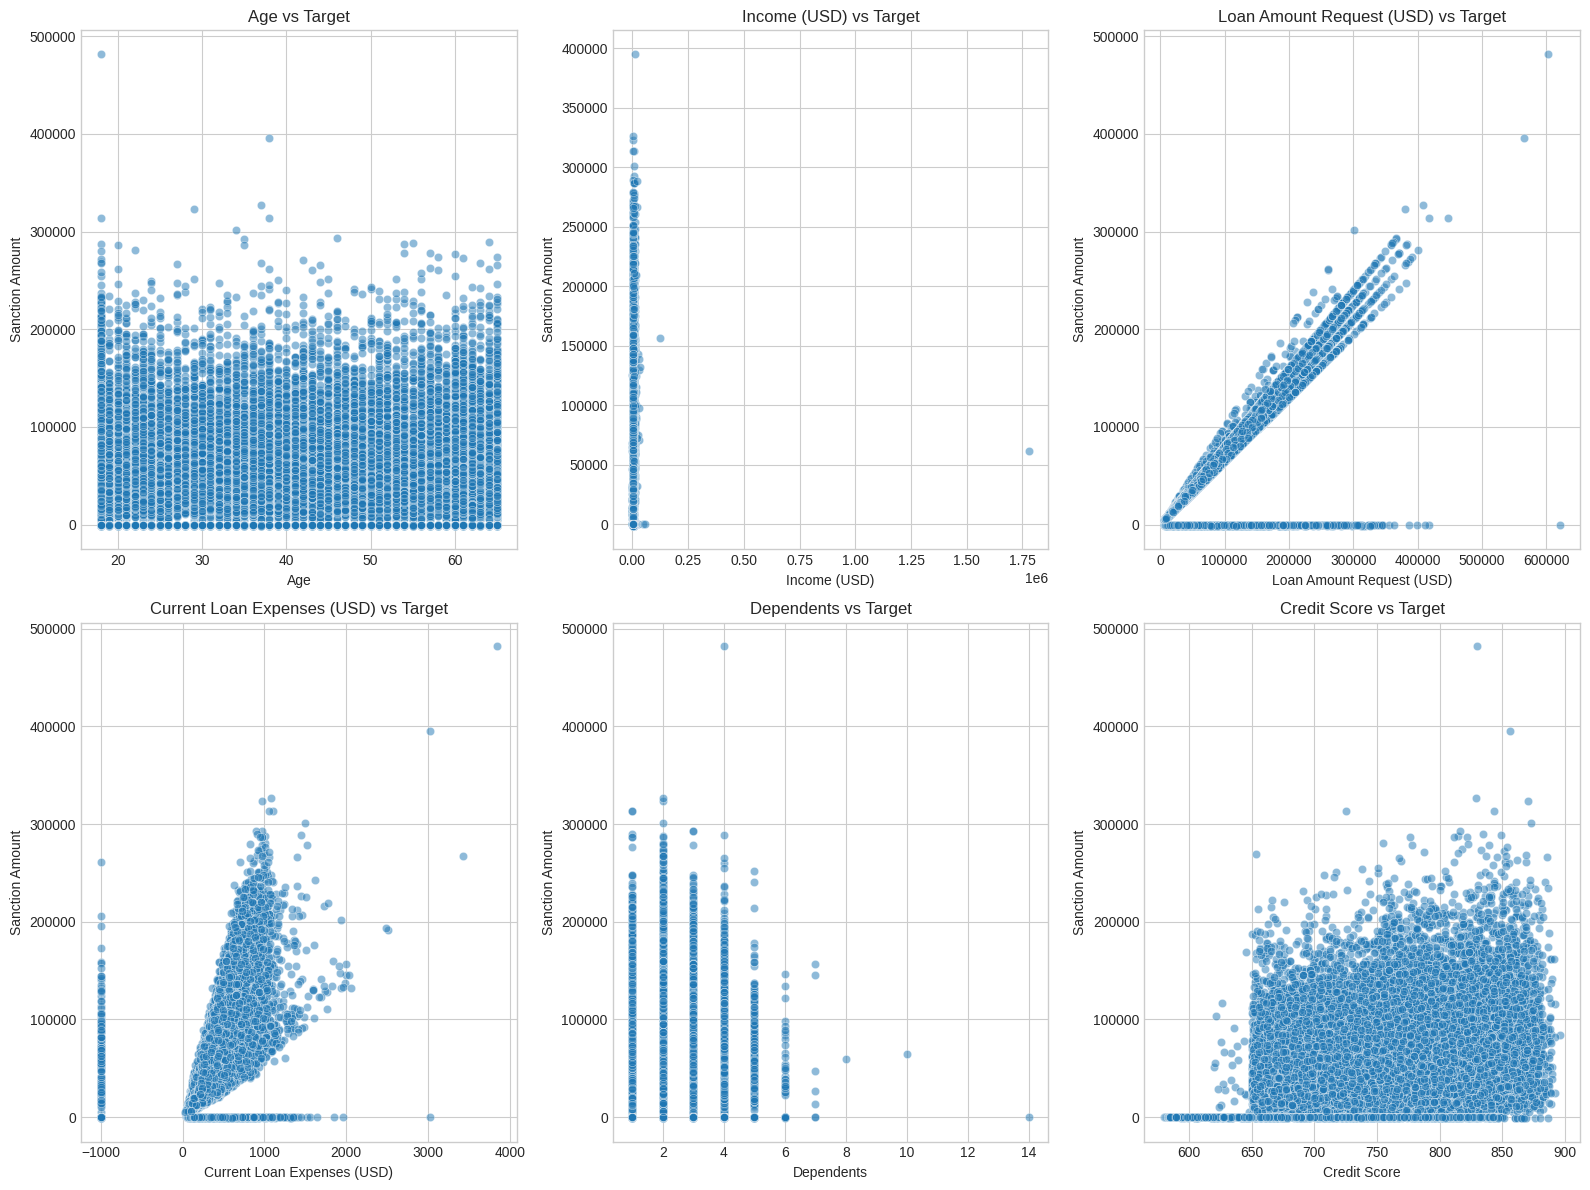

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(y, bins=50, kde=True, ax=ax[0], color='blue')
ax[0].set_title(f"Distribution of {TARGET}")
ax[0].set_xlabel("Amount (USD)")

sns.boxplot(x=y, ax=ax[1], color='green')
ax[1].set_title(f"Boxplot of {TARGET}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols[:6]):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=X[col], y=y, alpha=0.5)
    plt.title(f"{col} vs Target")
    plt.xlabel(col)
    plt.ylabel("Sanction Amount")
plt.tight_layout()
plt.show()

In [9]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


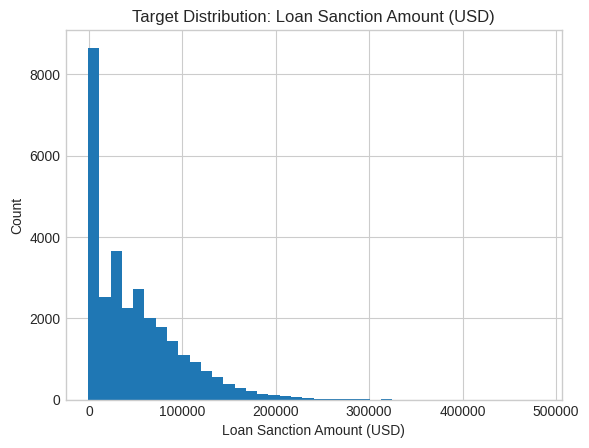

In [10]:
plt.figure()
plt.hist(y, bins=40)
plt.title("Target Distribution: Loan Sanction Amount (USD)")
plt.xlabel("Loan Sanction Amount (USD)")
plt.ylabel("Count")
plt.show()


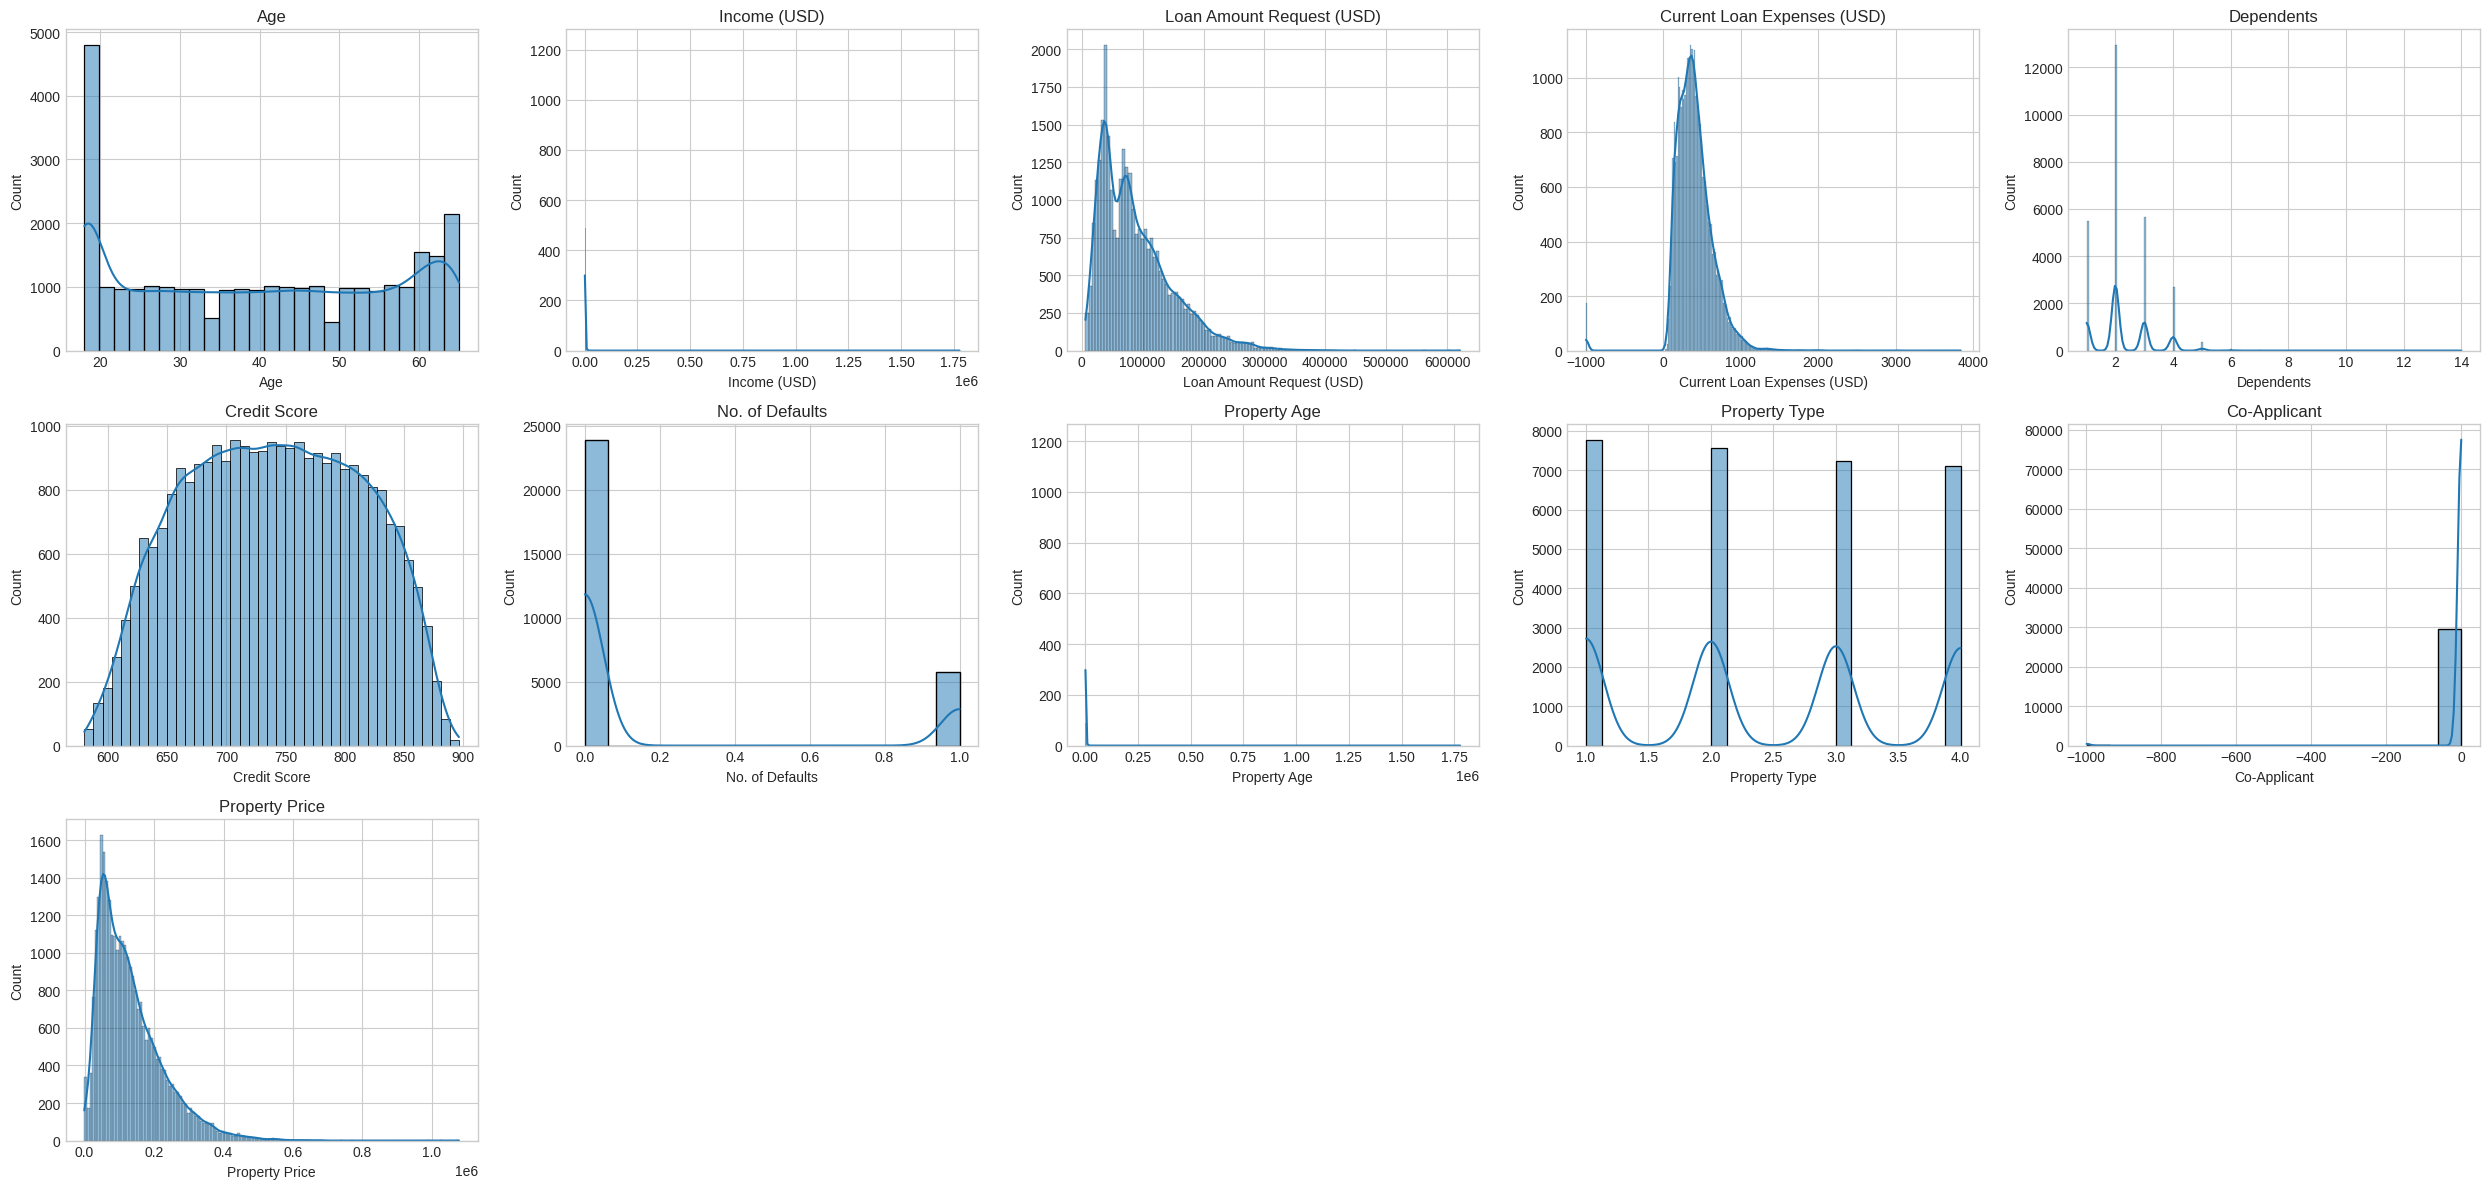

In [11]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

n = len(num_cols)
cols = 5
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(train_df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


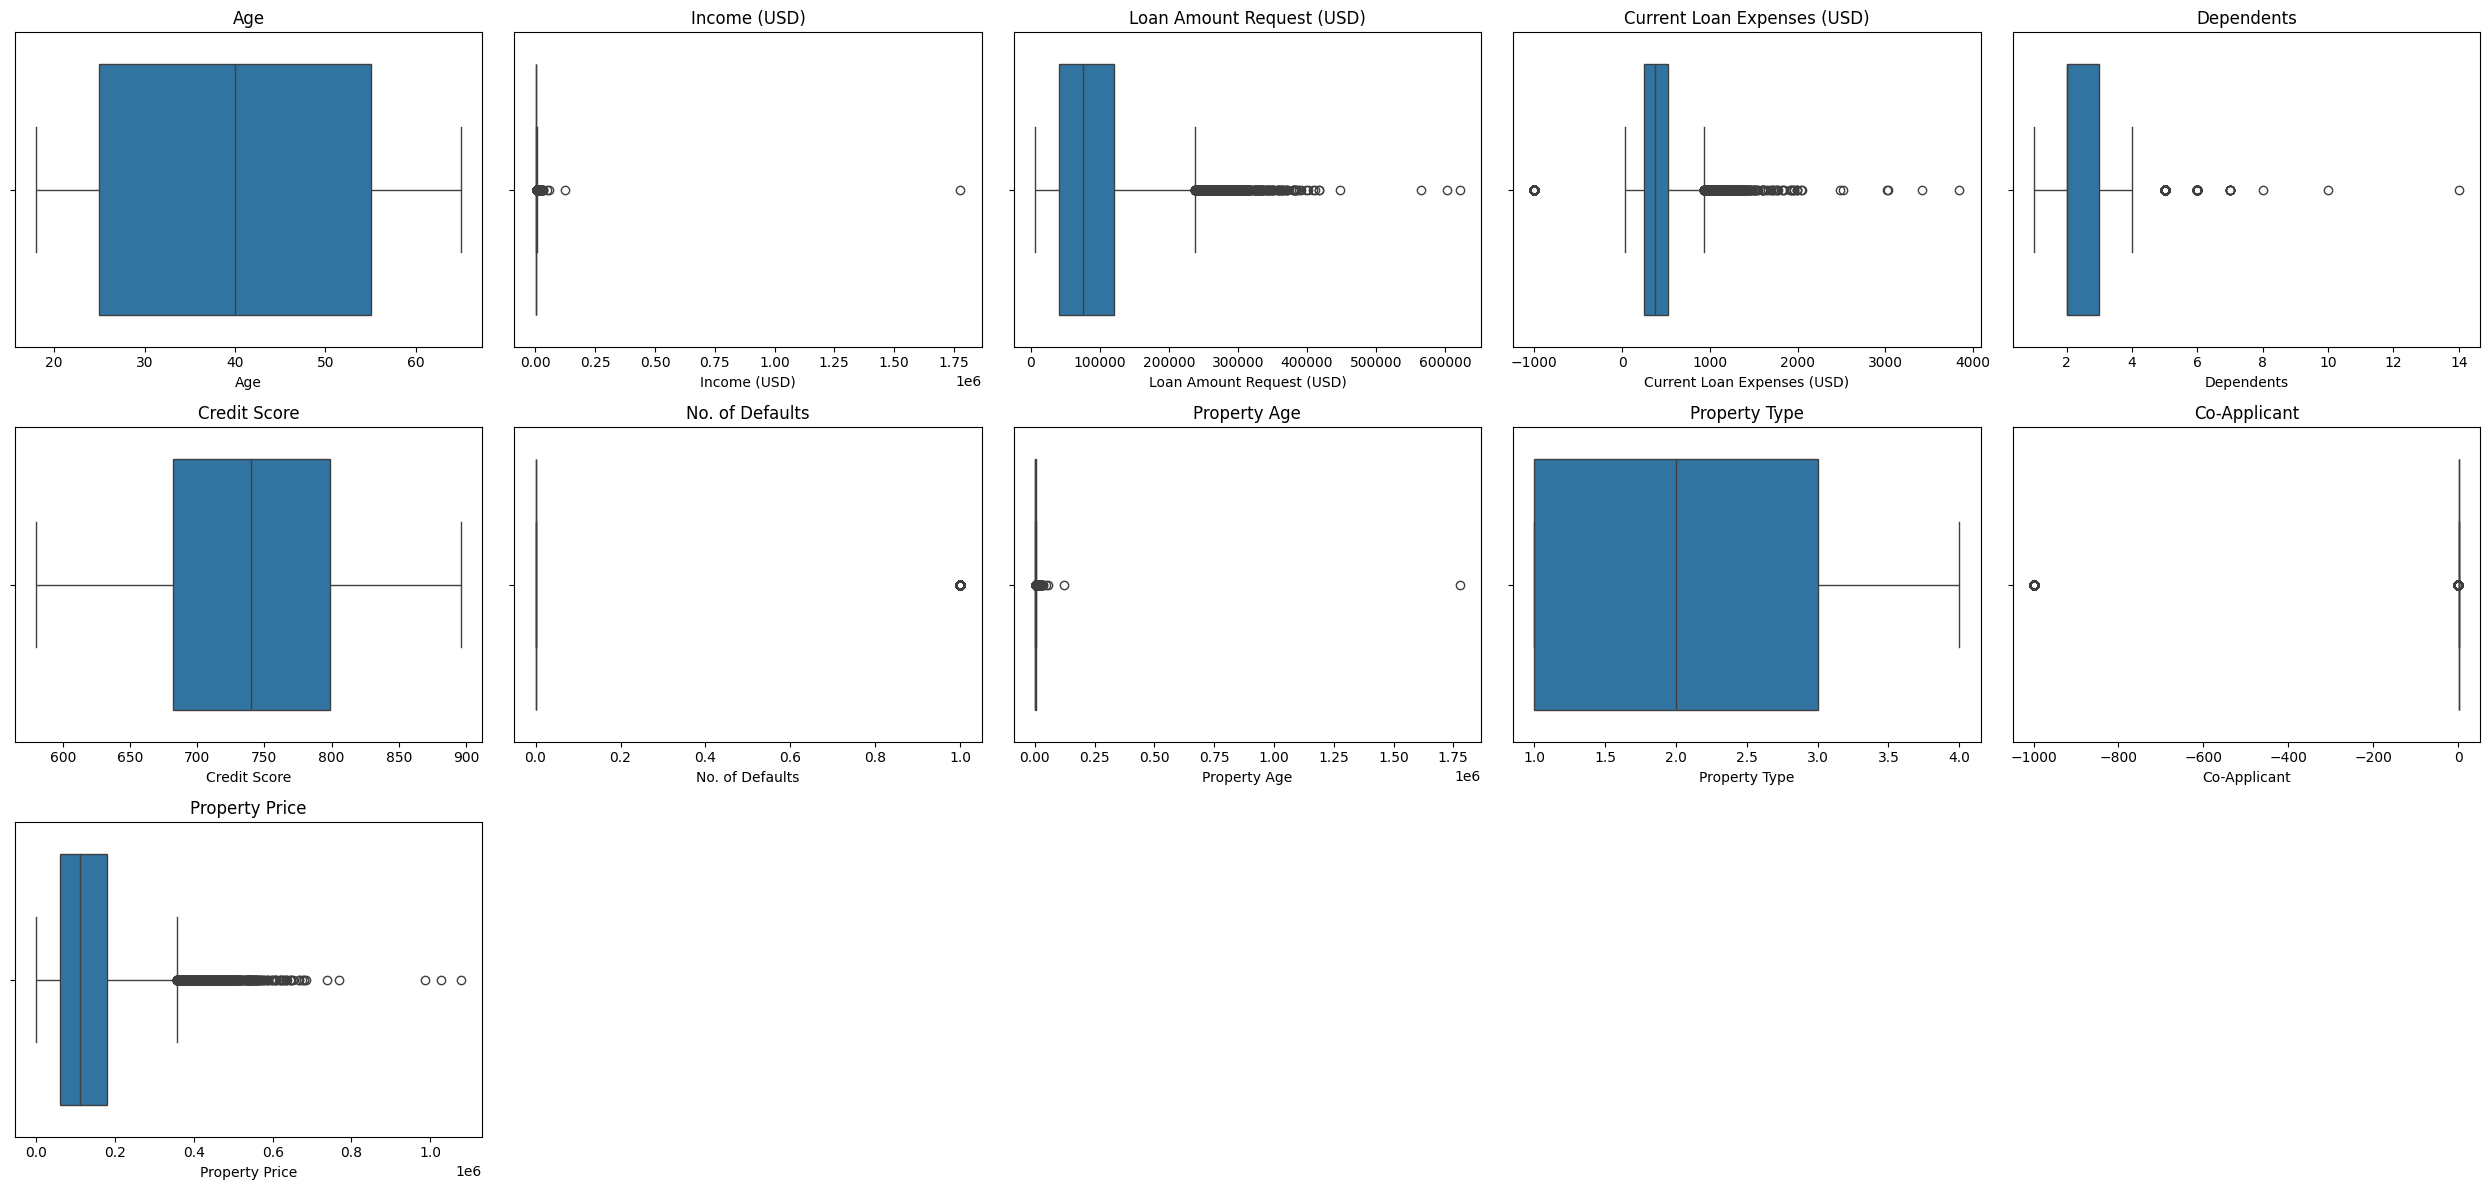

In [ ]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

n = len(num_cols)
cols = 5
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=train_df[col], ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


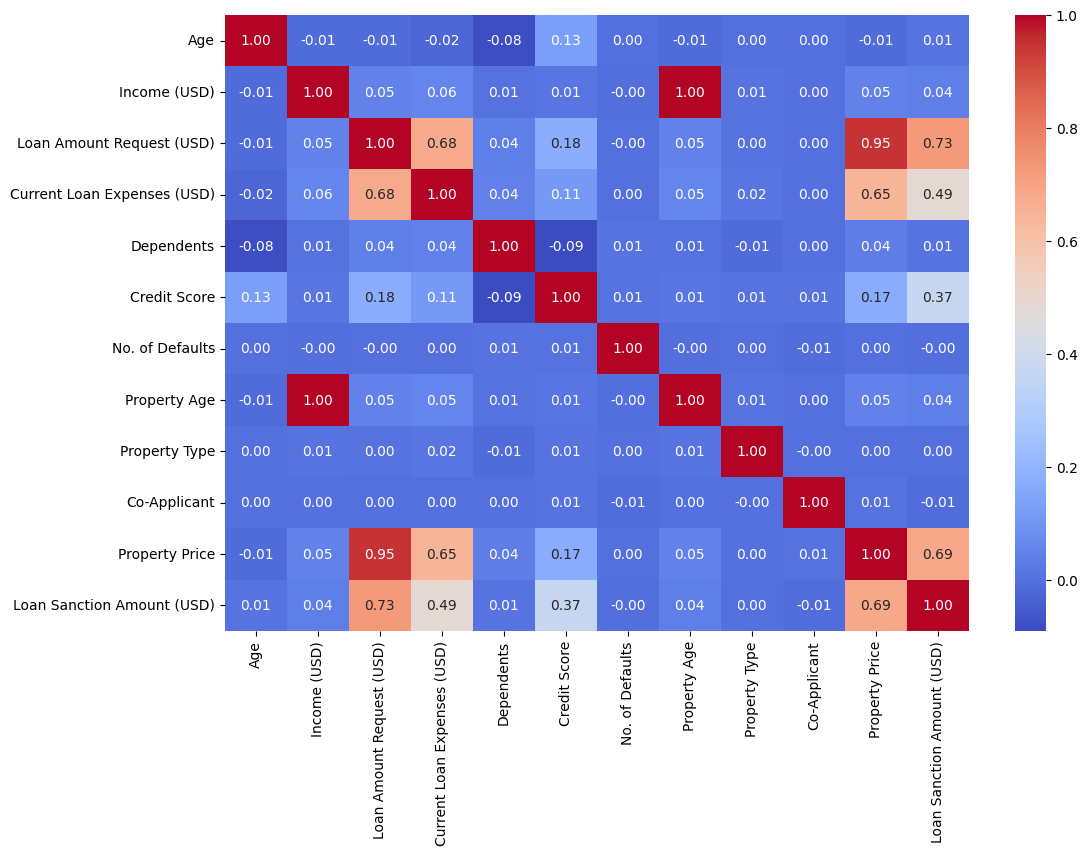

In [ ]:


corr = train_df[num_cols + [TARGET]].corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2


def fit_time_model(pipeline, Xtr, ytr):
    t0 = time.perf_counter()
    pipeline.fit(Xtr, ytr)
    t1 = time.perf_counter()
    return t1 - t0


In [ ]:
lin_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

lin_time = fit_time_model(lin_pipe, X_train, y_train)

lin_pred = lin_pipe.predict(X_test)
lin_mae, lin_mse, lin_rmse, lin_r2 = regression_metrics(y_test, lin_pred)


In [ ]:
print("Base Linear Regression Performance")
print(f"MAE  : {lin_mae:.4f}")
print(f"MSE  : {lin_mse:.4f}")
print(f"RMSE : {lin_rmse:.4f}")
print(f"R2   : {lin_r2:.4f}")
print(f"Training Time (s): {lin_time:.4f}")


Base Linear Regression Performance
MAE  : 21589.8579
MSE  : 1018911831.6068
RMSE : 31920.3984
R2   : 0.5511
Training Time (s): 0.1651


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

cv = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", Ridge(random_state=42))
])

lasso_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", Lasso(max_iter=20000, random_state=42))
])

enet_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", ElasticNet(max_iter=20000, random_state=42))
])

ridge_grid = {"model__alpha": [0.01, 0.1, 1, 10, 100]}
lasso_grid = {"model__alpha": [0.001, 0.01, 0.1, 1, 10]}
enet_grid  = {
    "model__alpha": [0.01, 0.1, 1, 10],
    "model__l1_ratio": [0.2, 0.5, 0.8]
}

def run_grid(pipe, grid):
    gs = GridSearchCV(pipe, grid, scoring="r2", cv=cv, n_jobs=-1)
    gs.fit(X_train, y_train)
    return gs

ridge_gs = run_grid(ridge_pipe, ridge_grid)
lasso_gs = run_grid(lasso_pipe, lasso_grid)
enet_gs  = run_grid(enet_pipe, enet_grid)

print("Hyperparameter Tuning Results")
print("Ridge  :", ridge_gs.best_params_, "Best CV R2:", ridge_gs.best_score_)
print("Lasso  :", lasso_gs.best_params_, "Best CV R2:", lasso_gs.best_score_)
print("Enet   :", enet_gs.best_params_,  "Best CV R2:", enet_gs.best_score_)


Hyperparameter Tuning Results
Ridge  : {'model__alpha': 100} Best CV R2: 0.5786469026956836
Lasso  : {'model__alpha': 10} Best CV R2: 0.5784551465036821
Enet   : {'model__alpha': 0.1, 'model__l1_ratio': 0.5} Best CV R2: 0.579838381020951


In [ ]:
def cv_metrics(pipe):
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, n_jobs=-1)
    mae  = mean_absolute_error(y_train, y_pred)
    mse  = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_train, y_pred)
    return mae, mse, rmse, r2

lin_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

ridge_best = ridge_gs.best_estimator_
lasso_best = lasso_gs.best_estimator_
enet_best  = enet_gs.best_estimator_

results = {
    "Linear Regression": cv_metrics(lin_pipe),
    "Ridge Regression":  cv_metrics(ridge_best),
    "Lasso Regression":  cv_metrics(lasso_best),
    "Elastic Net":       cv_metrics(enet_best)
}

print("\nCross-Validation Performance (K = 5)")
for model, (mae, mse, rmse, r2) in results.items():
    print(model)
    print(f"MAE: {mae:.4f}  MSE: {mse:.4f}  RMSE: {rmse:.4f}  R2: {r2:.4f}\n")



Cross-Validation Performance (K = 5)
Linear Regression
MAE: 21508.1142  MSE: 984727093.1145  RMSE: 31380.3616  R2: 0.5790

Ridge Regression
MAE: 21524.7473  MSE: 983019851.6404  RMSE: 31353.1474  R2: 0.5797

Lasso Regression
MAE: 21497.8842  MSE: 983433813.8426  RMSE: 31359.7483  R2: 0.5796

Elastic Net
MAE: 21732.7267  MSE: 980735482.7595  RMSE: 31316.6965  R2: 0.5807



In [ ]:
lin_pipe.fit(X_train, y_train)
lin_pred   = lin_pipe.predict(X_test)
ridge_pred = ridge_best.predict(X_test)
lasso_pred = lasso_best.predict(X_test)
enet_pred  = enet_best.predict(X_test)
model_names = ["Linear Regression", "Ridge Regression", "Lasso Regression", "Elastic Net"]
predictions = [lin_pred, ridge_pred, lasso_pred, enet_pred]
metrics_data = []

for name, pred in zip(model_names, predictions):
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)
    metrics_data.append([name, mae, mse, rmse, r2])

table_3 = pd.DataFrame(metrics_data, columns=["Model", "MAE", "MSE", "RMSE", "R2"])

print("\n" + "="*40)
print("Table 3: Test Set Performance")
print("="*40)
print(table_3.round(4).to_string(index=False))


Table 3: Test Set Performance
            Model        MAE          MSE       RMSE     R2
Linear Regression 21589.8579 1.018912e+09 31920.3984 0.5511
 Ridge Regression 21582.3204 1.017227e+09 31893.9988 0.5518
 Lasso Regression 21564.5711 1.017745e+09 31902.1118 0.5516
      Elastic Net 21751.6900 1.018489e+09 31913.7778 0.5513


In [ ]:
try:
    coef_data = {
        "Linear": lin_pipe.named_steps['model'].coef_,
        "Ridge": ridge_best.named_steps['model'].coef_,
        "Lasso": lasso_best.named_steps['model'].coef_,
        "Elastic Net": enet_best.named_steps['model'].coef_
    }

    table_4 = pd.DataFrame(coef_data)


    table_4.insert(0, "Feature", [f"Feature {i+1}" for i in range(len(table_4))])

    print("\n" + "="*40)
    print("Table 4: Coefficient Comparison")
    print("="*40)
    print(table_4.round(4).to_string(index=False))

except AttributeError:
    print("\nCould not extract coefficients.")


Table 4: Coefficient Comparison
   Feature      Linear      Ridge      Lasso  Elastic Net
 Feature 1   -611.2941  -580.5143  -576.6711    -558.6418
 Feature 2  47656.5397  1039.4816     3.8451      97.4573
 Feature 3  35365.3700 33825.7866 35169.9575   25155.4719
 Feature 4  -1249.5573 -1046.9052 -1195.3712     319.8903
 Feature 5   -100.1356   -98.1434   -87.8898     -73.8574
 Feature 6  11637.8108 11622.6246 11649.6648   11286.2195
 Feature 7   -281.0038  -286.0285  -274.8641    -292.3420
 Feature 8 -47644.1150 -1031.7350     0.0000     -86.5072
 Feature 9   -203.0639  -200.9657  -194.1327    -201.1066
Feature 10   -510.3661  -516.7131  -502.3532    -531.9812
Feature 11  -1328.1109    23.9503 -1143.8051    7064.8769
Feature 12  -4831.9845 -2818.7806 -6352.0233    -705.7281
Feature 13   4831.9845  2818.7806     0.0000     705.7280
Feature 14  12582.6388   129.2804     0.0000      11.4157
Feature 15  -1064.1793  -717.2601    63.6791     136.2042
Feature 16   6613.8995  2989.5967  4449

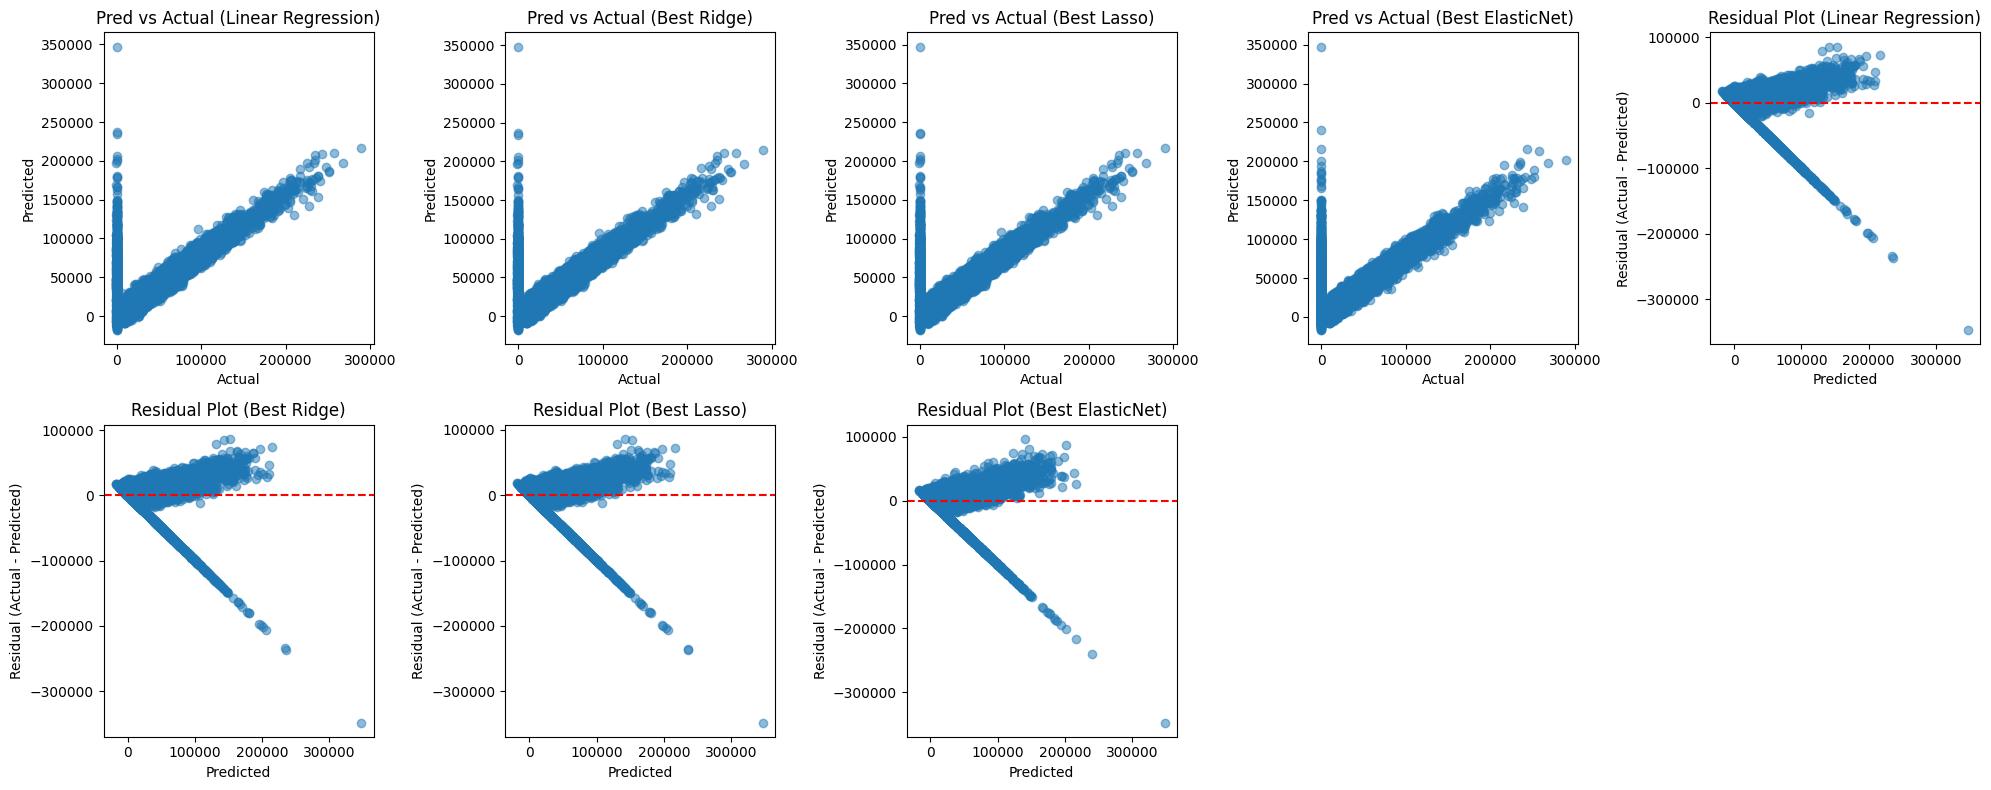

In [ ]:
import matplotlib.pyplot as plt

models = ["Linear Regression", "Best Ridge", "Best Lasso", "Best ElasticNet"]
predictions = [lin_pred, ridge_pred, lasso_pred, enet_pred]

cols = 5
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

for i, (pred, model) in enumerate(zip(predictions, models)):
    axes[i].scatter(y_test, pred, alpha=0.5)
    axes[i].set_title(f"Pred vs Actual ({model})")
    axes[i].set_xlabel("Actual")
    axes[i].set_ylabel("Predicted")

for i, (pred, model) in enumerate(zip(predictions, models), start=4):
    residuals = y_test - pred
    axes[i].scatter(pred, residuals, alpha=0.5)
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(f"Residual Plot ({model})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Residual (Actual - Predicted)")

for j in range(len(predictions)*2, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


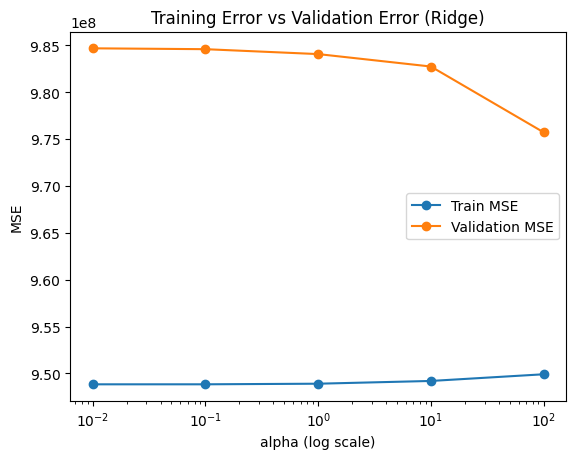

In [ ]:

alphas = np.array([0.01, 0.1, 1, 10, 100])

train_scores, val_scores = validation_curve(
    Ridge(random_state=42),
    X=preprocess.fit_transform(X_train),
    y=y_train,
    param_name="alpha",
    param_range=alphas,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

train_mse = -train_scores.mean(axis=1)
val_mse   = -val_scores.mean(axis=1)

plt.figure()
plt.plot(alphas, train_mse, marker="o", label="Train MSE")
plt.plot(alphas, val_mse, marker="o", label="Validation MSE")
plt.xscale("log")
plt.title("Training Error vs Validation Error (Ridge)")
plt.xlabel("alpha (log scale)")
plt.ylabel("MSE")
plt.legend()
plt.show()


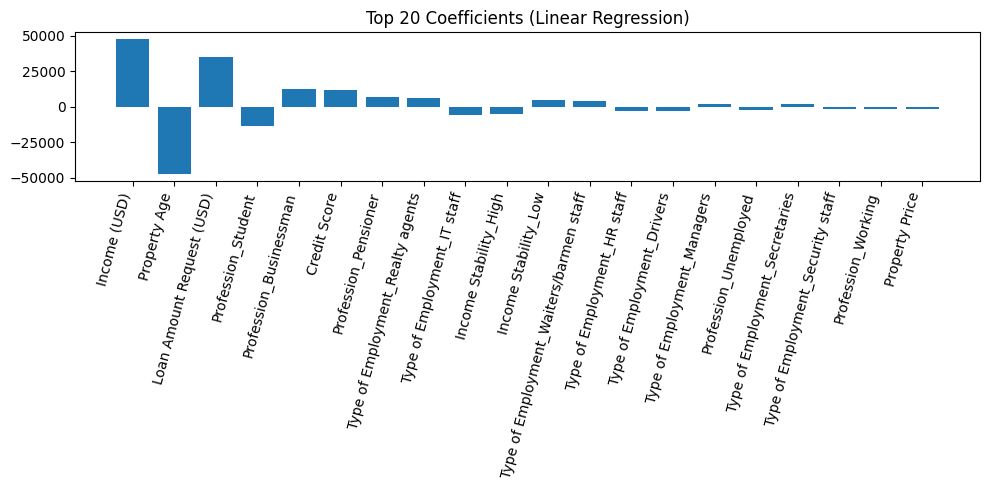

In [ ]:
def get_feature_names(preprocessor):
    num_features = num_cols
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_features = ohe.get_feature_names_out(cat_cols).tolist()
    return num_features + cat_features

def get_coefs(model_pipeline):
    pre = model_pipeline.named_steps["preprocess"]
    model = model_pipeline.named_steps["model"]
    feat_names = get_feature_names(pre)
    coefs = model.coef_
    return feat_names, coefs


lin_feats, lin_coefs = get_coefs(lin_pipe)
ridge_feats, ridge_coefs = get_coefs(ridge_best)
lasso_feats, lasso_coefs = get_coefs(lasso_best)
enet_feats, enet_coefs = get_coefs(enet_best)


top_k = 20
idx = np.argsort(np.abs(lin_coefs))[::-1][:top_k]

plt.figure(figsize=(10, 5))
plt.bar(np.array(lin_feats)[idx], lin_coefs[idx])
plt.title(f"Top {top_k} Coefficients (Linear Regression)")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
test_df

,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price
0,47,3472.69,Low,Commercial associate,Managers,Semi-Urban,137088.98,396.72,N,N,2.0,799.14,0,Unpossessed,3472.69,2,Urban,1,236644.5
1,57,1184.84,Low,Working,Sales staff,Rural,104771.59,463.76,Y,Y,2.0,833.31,0,Unpossessed,1184.84,1,Rural,1,142357.3
2,52,1266.27,Low,Working,NaN,Semi-Urban,176684.91,493.15,N,Y,3.0,627.44,0,Unpossessed,1266.27,1,Urban,1,300991.24
3,65,1369.72,High,Pensioner,NaN,Rural,97009.18,446.15,N,Y,2.0,833.20,0,Inactive,1369.72,1,Semi-Urban,0,125612.1
4,60,1939.23,High,Pensioner,NaN,Urban,109980.00,370.10,N,N,NaN,NaN,0,NaN,1939.23,4,Semi-Urban,1,180908.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19,1349.60,Low,Commercial associate,NaN,Semi-Urban,156766.97,500.59,Y,Y,4.0,684.32,0,Inactive,1349.60,4,Semi-Urban,1,212778.0
19996,22,2019.78,Low,Working,Core staff,Urban,47924.80,243.02,Y,Y,NaN,706.34,0,Inactive,2019.78,4,Urban,1,90816.95
19997,19,2252.03,Low,Working,Core staff,Semi-Urban,18629.88,101.88,Y,N,1.0,656.46,0,Inactive,2252.03,2,Rural,0,21566.27
19998,21,1845.35,Low,Working,NaN,Semi-Urban,95430.73,271.31,N,Y,2.0,865.46,0,Unpossessed,1845.35,1,Semi-Urban,1,120281.17


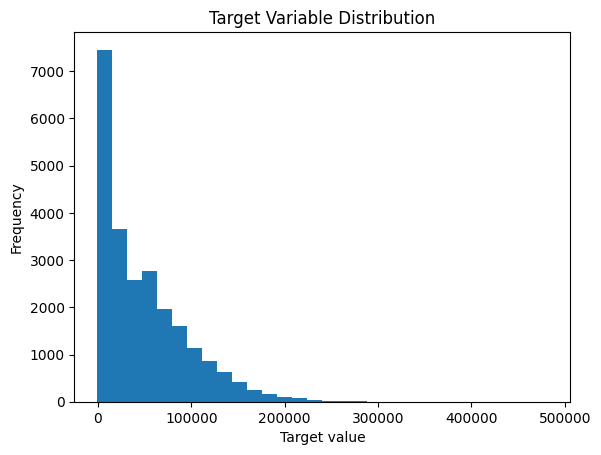

In [ ]:
plt.figure()
plt.hist(y_train, bins=30)
plt.xlabel("Target value")
plt.ylabel("Frequency")
plt.title("Target Variable Distribution")
plt.show()


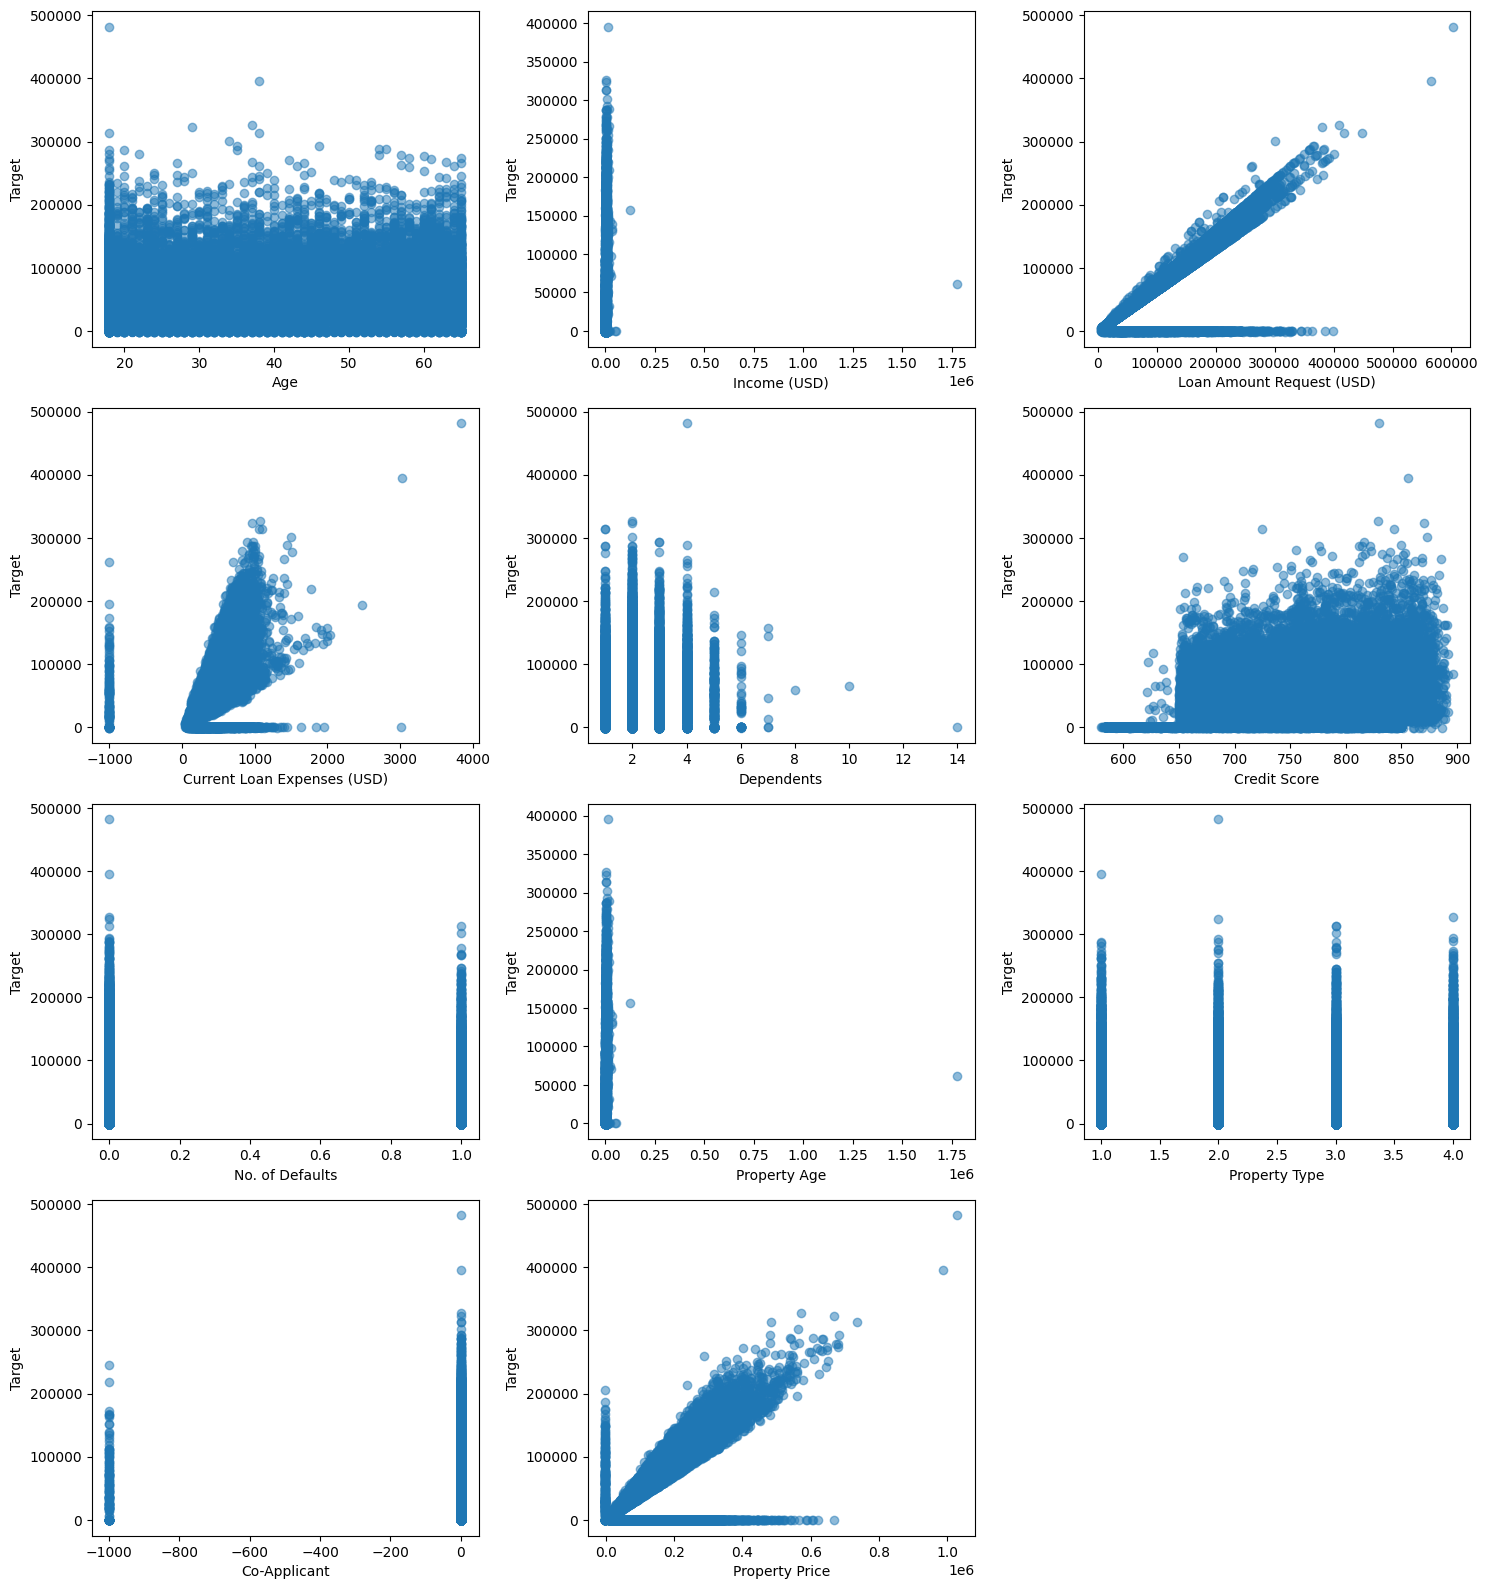

In [ ]:
n_feats = len(num_cols)
cols = 3
rows = (n_feats + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].scatter(X_train[col], y_train, alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Target")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


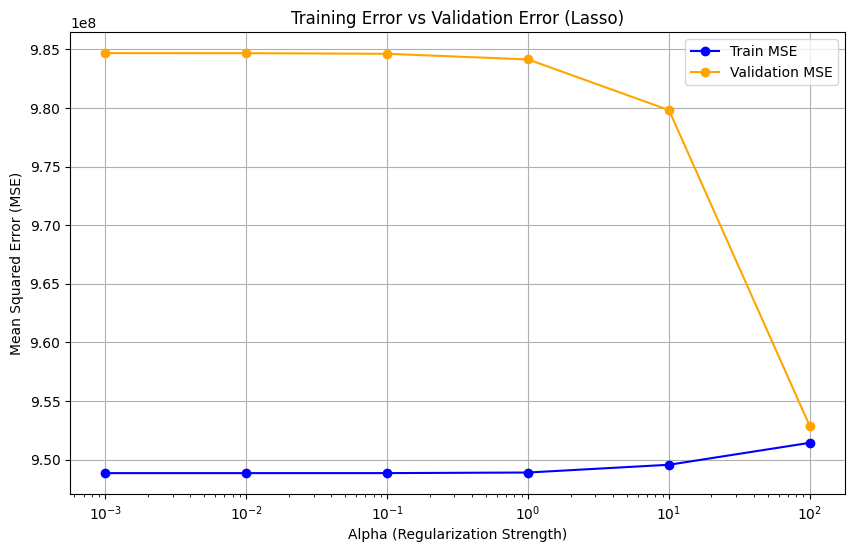

Alpha		Train MSE	Validation MSE
0.001		948838398		984689292
0.010		948838475		984684496
0.100		948839813		984631754
1.000		948890294		984150326
10.000		949552553		979820958
100.000		951428002		952826351


In [ ]:
alphas_lasso = np.logspace(-3, 2, 6)


train_scores_lasso, val_scores_lasso = validation_curve(
    Lasso(random_state=42, max_iter=20000),
    X=preprocess.fit_transform(X_train),
    y=y_train,
    param_name="alpha",
    param_range=alphas_lasso,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)


train_mse_lasso = -train_scores_lasso.mean(axis=1)
val_mse_lasso = -val_scores_lasso.mean(axis=1)


plt.figure(figsize=(10, 6))
plt.plot(alphas_lasso, train_mse_lasso, marker="o", label="Train MSE", color="blue")
plt.plot(alphas_lasso, val_mse_lasso, marker="o", label="Validation MSE", color="orange")


plt.xscale("log")
plt.title("Training Error vs Validation Error (Lasso)")
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()


print("Alpha\t\tTrain MSE\tValidation MSE")
for a, t, v in zip(alphas_lasso, train_mse_lasso, val_mse_lasso):
    print(f"{a:.3f}\t\t{t:.0f}\t\t{v:.0f}")

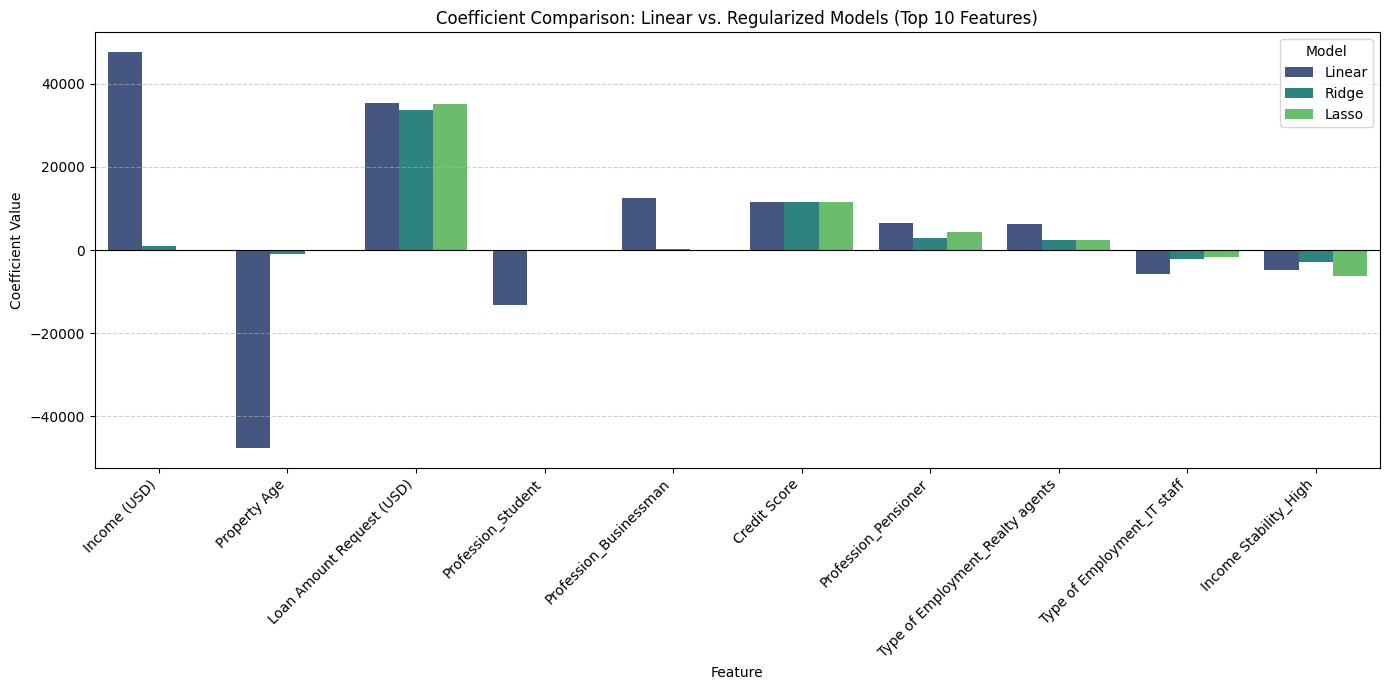

In [ ]:
feat_names, lin_c = get_coefs(lin_pipe)
_, lasso_c = get_coefs(lasso_best)
_, ridge_c = get_coefs(ridge_best)
_, enet_c = get_coefs(enet_best)
coef_df = pd.DataFrame({
    "Feature": feat_names,
    "Linear": lin_c,
    "Ridge": ridge_c,
    "Lasso": lasso_c,
    "ElasticNet": enet_c
})
top_n = 10
coef_df["Linear_Abs"] = coef_df["Linear"].abs()
top_features = coef_df.sort_values("Linear_Abs", ascending=False).head(top_n)
df_melted = top_features.melt(
    id_vars="Feature",
    value_vars=["Linear", "Ridge", "Lasso"],
    var_name="Model",
    value_name="Coefficient"
)
plt.figure(figsize=(14, 7))
sns.barplot(data=df_melted, x="Feature", y="Coefficient", hue="Model", palette="viridis")
plt.title(f"Coefficient Comparison: Linear vs. Regularized Models (Top {top_n} Features)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Coefficient Value")
plt.axhline(0, color="black", linewidth=0.8)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()